# 🌍🛰️ Planet: Understanding the Amazon from Space
## Use satellite data to track the human footprint in the Amazon rainforest

### Description
🌍🛰️ Planet Aerial Imagery

Every passing minute, an expanse of forest equivalent to 48 football fields disappears from our planet. The Amazon Basin takes the lead in this alarming deforestation trend, contributing to biodiversity loss, habitat destruction, climate change, and other catastrophic effects. Precise data on deforestation and human activities in forests is crucial for swift and effective responses from governments and local stakeholders.

🛰️ Planet, the innovator behind the world’s largest fleet of Earth-imaging satellites, is set to capture daily imagery of the entire Earth's land surface at an impressive 3-5 meter resolution. While existing research focuses on monitoring forest changes, it often relies on coarse-resolution imagery from sources like Landsat (30-meter pixels) or MODIS (250-meter pixels), limiting its effectiveness in areas dominated by small-scale deforestation or forest degradation.

Moreover, current methods struggle to distinguish between human-induced and natural forest loss. Higher resolution imagery, such as that from Planet, has demonstrated exceptional capability in this regard, but robust algorithms are yet to be developed.

🌈 In this competition, Planet and its Brazilian partner SCCON invite Kagglers to colorfully label satellite image chips with atmospheric conditions and various classes of land cover/land use. The resulting algorithms will empower the global community to comprehensively understand when, where, and why deforestation occurs worldwide—and, most importantly, how to respond effectively. 🚀✨

In [25]:
import os
path = "../input/planets-dataset/"
os.listdir(path)

['planet', 'test-jpg-additional']

In [26]:
import pandas as pd
train_label = pd.read_csv("/kaggle/input/planets-dataset/planet/planet/train_classes.csv")
train_label

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [27]:
unique_labels = set()

def extract_unique_labels(tag_string):
    '''
    Takes in a string of tags, splits the tags, and stores them in a set
    '''
    [unique_labels.add(tag) for tag in tag_string.split()]

# Create a copy of the train_label DataFrame
train_data = train_label.copy()
# Apply the function to extract unique labels from the 'tags' column
train_data['tags'].apply(extract_unique_labels)
# Convert the set of unique labels to a list
unique_labels_list = list(unique_labels)
# Display the list of unique labels
print(unique_labels_list)

['cultivation', 'bare_ground', 'water', 'habitation', 'partly_cloudy', 'cloudy', 'selective_logging', 'road', 'agriculture', 'clear', 'haze', 'blooming', 'slash_burn', 'conventional_mine', 'artisinal_mine', 'blow_down', 'primary']


In [40]:
df = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


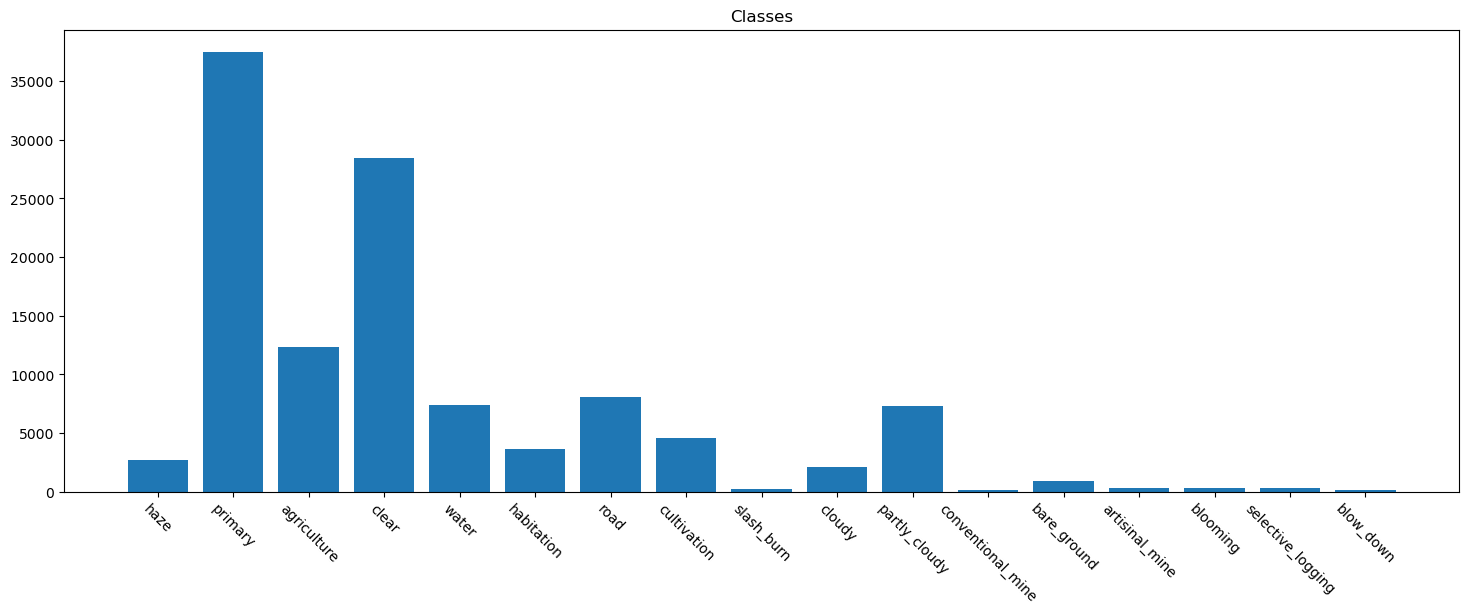

In [46]:
import matplotlib.pyplot as plt  # Make sure to import plt from matplotlib

# Total number of tags and their names.
counts = {}
splitted_tags = df['tags'].map(lambda x: x.split(' '))
for labels in splitted_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0

plt.figure(figsize=(18, 6))
plt.title('Classes')
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=-45)
plt.bar(idxs, counts.values())
plt.show()  # Display the plot


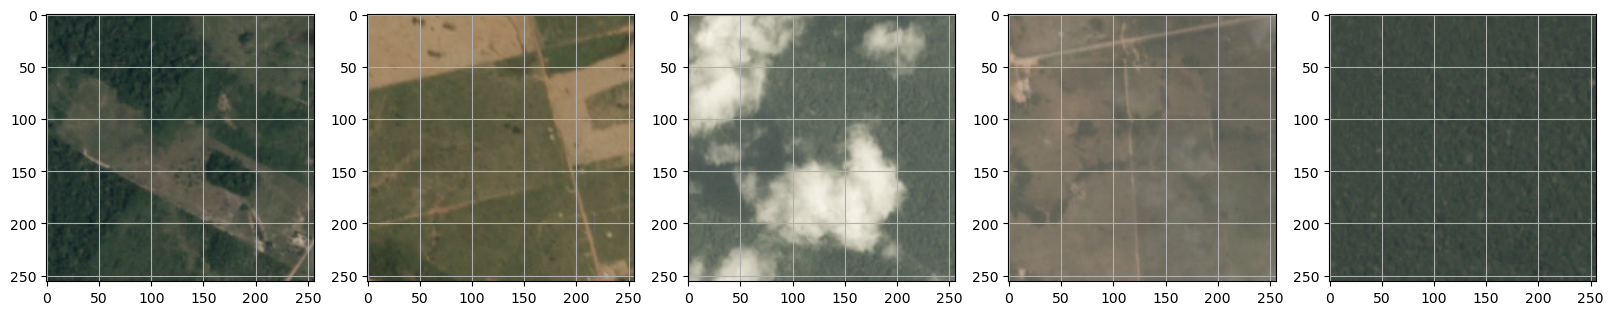

In [57]:
# Let's take a look at some random images.
plt.rc('axes', grid = True)

_, ax = plt.subplots(1, 5, figsize=(20, 20))
random_img = np.random.randint(0,len(df) - 5)
for i , (file, label) in enumerate(df[random_img:random_img + 5].values):
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(file))
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Flatten(),

    Dense(1024, activation='relu'),
    Dense(17, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta_score])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout_5 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

In [60]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

optimizer = Adam(learning_rate=0.003)

base_model = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 17)                2193      
                                                                 
Total params: 27,784,337
Trainable params: 27,731,217
Non-trainable params: 53,120
_________________________________________________________________


In [61]:
# Model Checkpoint
save_best_check_point = ModelCheckpoint(filepath='best_model.hdf5', 
                                        monitor='val_fbeta_score',
                                        mode='max',
                                        save_best_only=True,
                                        save_weights_only=False)

# Image Data Generator
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

# Train Data Generator
train_generator = train_datagen.flow_from_dataframe(dataframe=train_data,
                                                    directory="/kaggle/input/planets-dataset/planet/planet/train-jpg",
                                                    x_col="image_name", y_col=columns, subset="training",
                                                    batch_size=16, seed=42, shuffle=True,
                                                    class_mode="raw", target_size=(128, 128))

# Validation Data Generator
val_generator = train_datagen.flow_from_dataframe(dataframe=train_data,
                                                  directory="/kaggle/input/planets-dataset/planet/planet/train-jpg",
                                                  x_col="image_name", y_col=columns, subset="validation",
                                                  batch_size=16, seed=42, shuffle=True,
                                                  class_mode="raw", target_size=(128, 128))

# Step Sizes
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))


print('fitting our model using the parameters already defined') #fitting our model using the parameters already defined 
history = model.fit(
    x = train_generator, 
    steps_per_epoch = step_train_size, 
    validation_data = val_generator, 
    validation_steps = step_val_size,
    epochs = 1, 
    callbacks=[save_best_check_point]
)

Found 32384 validated image filenames.
Found 8095 validated image filenames.
fitting our model using the parameters already defined
2024/2024 [==============================] - 246s 105ms/step - loss: 0.2588 - fbeta_score: 0.6824 - val_loss: 0.1875 - val_fbeta_score: 0.7671


In [69]:
!ls


best_model.hdf5


In [70]:
print('Loading the sample submission file')
# Loading the sample submission file
sample_submission = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv')
print(sample_submission)

Loading the sample submission file
      image_name                                  tags
0         test_0  primary clear agriculture road water
1         test_1  primary clear agriculture road water
2         test_2  primary clear agriculture road water
3         test_3  primary clear agriculture road water
4         test_4  primary clear agriculture road water
...          ...                                   ...
61186  file_9995  primary clear agriculture road water
61187  file_9996  primary clear agriculture road water
61188  file_9997  primary clear agriculture road water
61189  file_9998  primary clear agriculture road water
61190  file_9999  primary clear agriculture road water

[61191 rows x 2 columns]


In [74]:
all_labels = splitted_tags.values
labels = list(set([y for x in all_labels for y in x]))
labels

['cultivation',
 'bare_ground',
 'water',
 'habitation',
 'partly_cloudy',
 'cloudy',
 'selective_logging',
 'road',
 'agriculture',
 'clear',
 'haze',
 'blooming',
 'slash_burn',
 'conventional_mine',
 'artisinal_mine',
 'blow_down',
 'primary']

In [84]:
import cv2
import numpy as np
from os import listdir
import csv

print('Initializing a second model for predictions')
from tensorflow.keras.models import load_model
# Load the best model
loaded_model = load_model('best_model.hdf5', custom_objects={'fbeta_score': fbeta_score})

print("Generating a csv file for submission to Kaggle.")

# Path to the test images
test_images_path = "/kaggle/input/planets-dataset/planet/planet/test-jpg"

# Generating a csv file for submission to Kaggle.
X_test = []
submission = []

batch_size = 128  # Set your desired batch size

# Process test images in batches
for file in listdir(test_images_path):
    filename = file.split('.')[0]

    img = cv2.imread(f'{test_images_path}/{filename}.jpg')
    targets = np.zeros(17)

    X_test.append(cv2.resize(img, (128, 128)))
    submission.append(filename)

    # Process in batches
    if len(X_test) == batch_size:
        X_test_batch = np.array(X_test, np.float16) / 255
        y_test_batch = loaded_model.predict(X_test_batch, batch_size=batch_size)

        with open('understanding_the_amazon_from_space.csv', 'a', newline='') as csvfile:
            csv_writer = csv.writer(csvfile, delimiter=',',
                                    quotechar='|', quoting=csv.QUOTE_MINIMAL)
            for i, image in enumerate(submission):
                csv_writer.writerow((image, ' '.join(np.array(labels)[y_test_batch[i] > 0.2])))

        # Clear the lists for the next batch
        X_test = []
        submission = []

# Process the remaining images
if X_test:
    X_test_batch = np.array(X_test, np.float16) / 255
    y_test_batch = loaded_model.predict(X_test_batch, batch_size=len(X_test))

    with open('understanding_the_amazon_from_space.csv', 'a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for i, image in enumerate(submission):
            csv_writer.writerow((image, ' '.join(np.array(labels)[y_test_batch[i] > 0.2])))


Initializing a second model for predictions
Generating a csv file for submission to Kaggle.
1/1 [==============================] - 1s 1s/step


In [85]:
!ls

best_model.hdf5  understanding_the_amazon_from_space.csv


In [86]:
pd.read_csv('understanding_the_amazon_from_space.csv')

,test_39140,water partly_cloudy agriculture primary
0,test_4849,water road agriculture clear haze primary
1,test_18979,water partly_cloudy agriculture primary
2,test_24790,cloudy
3,test_30624,clear primary
4,test_7922,clear primary
...,...,...
40663,test_18830,partly_cloudy primary
40664,test_16161,clear primary
40665,test_28240,water partly_cloudy cloudy road agriculture pr...
40666,test_880,clear primary
